In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
# %matplotlib notebook

import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

import superscreen as sc

from huber_squid import huber_squid, huber_geometry

In [2]:
# def huber_field_coil(interp_points=None):
#     squid = huber_squid(interp_points)
    
#     return sc.Device(
#         "huber_field_coil",
#         layers=[squid.layers["BE"]],
#         films=[squid.films["fc"]],
#         holes=[squid.holes["fc_center"]],
#         abstract_regions=[squid.abstract_regions["bounding_box"]],
#         length_units=squid.length_units,
#     )

# def huber_without_field_coil(interp_points=None):
#     squid = huber_squid(interp_points)
    
#     layers = squid.layers
#     _ = layers.pop("BE")
#     films = squid.films
#     _ = films.pop("fc")
#     # _ = films.pop("fc_shield", None)
#     holes = squid.holes
#     _ = holes.pop("fc_center")
    
#     return sc.Device(
#         "huber_without_field_coil",
#         layers=layers,
#         films=films,
#         holes=holes,
#         abstract_regions=squid.abstract_regions,
#         length_units=squid.length_units,
#     )

In [5]:
squid = huber_squid()

layers = squid.layers
# layers["sample_layer"] = sc.Layer("sample_layer", Lambda=0.08, z0=0.0)

sample_points = np.array(
    [
        [-15.0, -15.0],
        [-15.0,  15.0],
        [ 15.0,  15.0],
        [ 15.0, -15.0],
    ]
)

films = squid.films
# films["sample"] = sc.Polygon(
#     "sample",
#     layer="sample_layer",
#     points=sample_points,
# )

holes = squid.holes
# holes["fc_center"] = sc.Polygon(
#     "fc_center",
#     layer=holes["fc_center"].layer,
#     points=holes["fc_center"].points[20:-25],
# )

squid.layers = layers
squid.films = films
squid.holes = holes

In [7]:
squid.make_mesh(min_triangles=10000, optimesh_steps=200)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 10053 triangles.
INFO:superscreen.device:Finished generating mesh with 5111 points and 10053 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


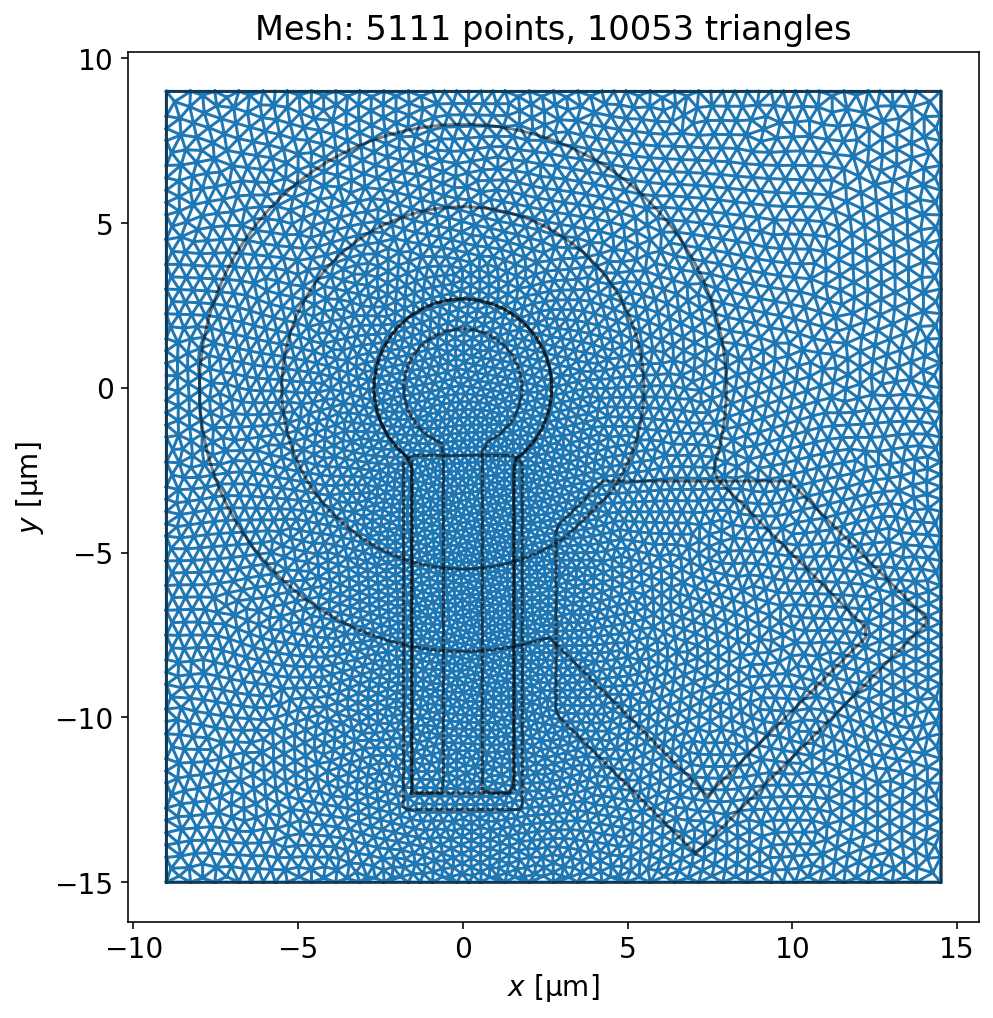

In [8]:
ax = squid.plot_mesh()
ax = squid.plot_polygons(ax=ax, color='k', alpha=0.5, legend=False)
_ = ax.set_title(
    f"Mesh: {squid.points.shape[0]} points, "
    f"{squid.triangles.shape[0]} triangles"
)
ax.figure.set_size_inches(8,8)

In [9]:
applied_field = sc.sources.ConstantField(0.0)

circulating_currents = {
    "fc_center": "1 mA"
}

solutions = sc.solve(
    device=squid,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="Phi_0/um**2",
    current_units="uA",
    iterations=6,
    coupled=True,
)
field_coil_solution = solutions[-1]

INFO:superscreen.brandt:Calculating BE response to applied field.
INFO:superscreen.brandt:Calculating W1 response to applied field.
INFO:superscreen.brandt:Calculating W2 response to applied field.
INFO:superscreen.brandt:Calculating screening field at BE from W1 (1/6).
INFO:superscreen.brandt:Calculating screening field at BE from W2 (1/6).
INFO:superscreen.brandt:Calculating screening field at W1 from BE (1/6).
INFO:superscreen.brandt:Calculating screening field at W1 from W2 (1/6).
INFO:superscreen.brandt:Calculating screening field at W2 from BE (1/6).
INFO:superscreen.brandt:Calculating screening field at W2 from W1 (1/6).
INFO:superscreen.brandt:Calculating BE response to applied field and screening field from other layers (1/6).
INFO:superscreen.brandt:Calculating W1 response to applied field and screening field from other layers (1/6).
INFO:superscreen.brandt:Calculating W2 response to applied field and screening field from other layers (1/6).
INFO:superscreen.brandt:Calculatin

In [10]:
records = []
for s in solutions:
    records.append(s.polygon_flux(units="Phi_0", with_units=False))
df = pd.DataFrame.from_records(records)
df.index.name = "Iteration"

In [11]:
df

,fc,fc_shield,pl,pl_shield,fc_center,bounding_box,pl_hull
Iteration,,,,,,,
0,5.680920,0.000000,0.000000,0.000000,3.424274,0.000000,0.000000
1,5.680920,0.026545,0.343837,0.071424,3.424274,4.218897,1.229515
2,5.340137,0.032966,0.304765,0.066222,3.258855,4.157289,1.027010
3,5.360268,0.032662,0.310392,0.069965,3.315463,4.158362,1.032773
4,5.341222,0.033169,0.306444,0.069354,3.296867,4.154553,1.021114
5,5.345174,0.033114,0.306965,0.069744,3.303502,4.154826,1.022356
6,5.343000,0.033169,0.306557,0.069685,3.301291,4.154460,1.021222


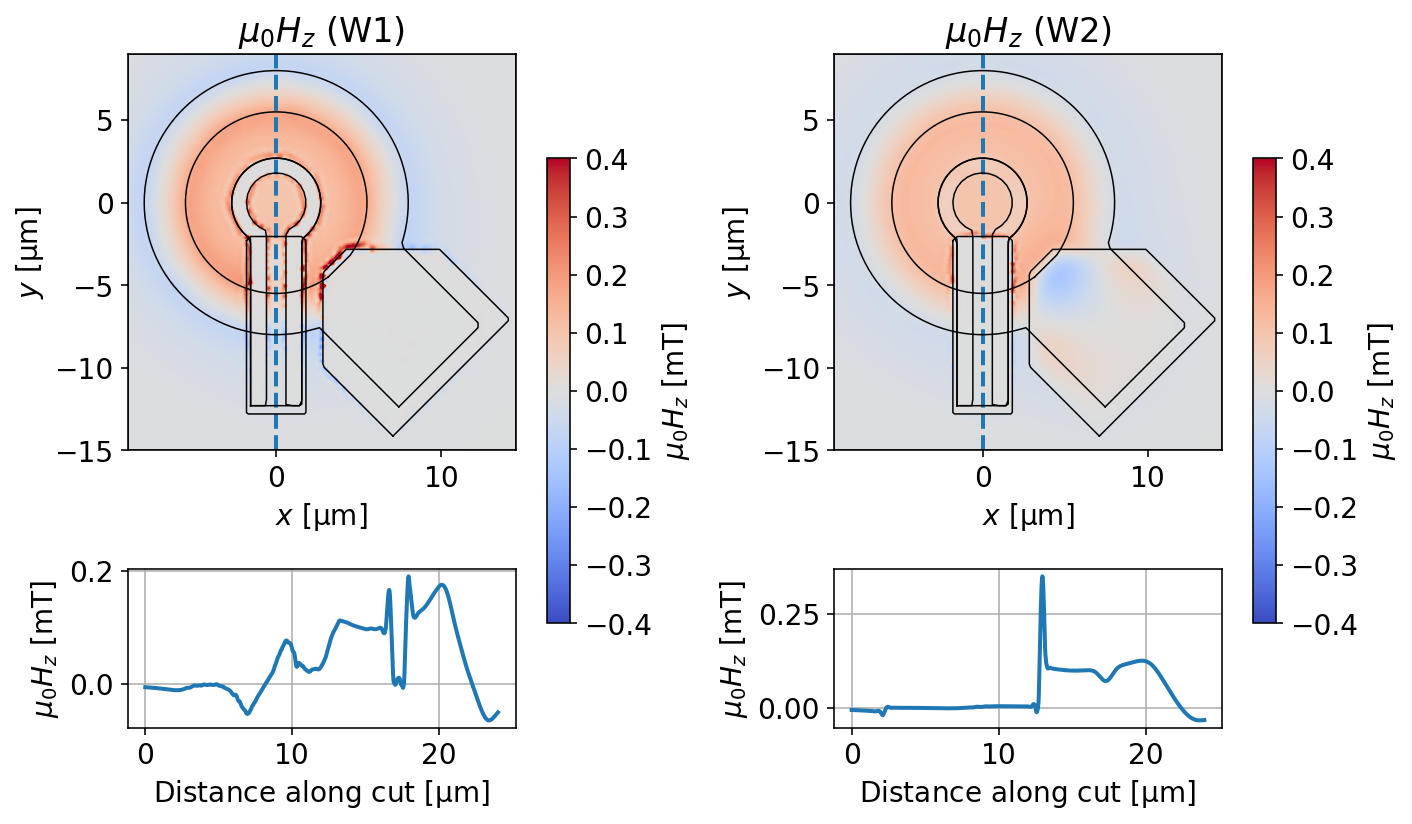

In [17]:
for solution in solutions[-1:]:
    fig, axes = sc.plot_fields(
        solution,
        layers=["W1", "W2"],
        units="mT",
        cmap="coolwarm",
        figsize=(10,6),
        grid_shape=(1000, 1000),
        cross_section_xs=0,
        cross_section_angle=0,
        vmin=-0.4, vmax=0.4,
    )
    for ax in axes:
        squid.plot_polygons(ax=ax, legend=False, color='k', lw=0.75)
        # field_coil.plot_polygons(ax=ax, legend=False, color='k', lw=0.75)

In [13]:
flux = solutions[-1].polygon_flux()
I_circ = squid.ureg(solutions[-1].circulating_currents["fc_center"])
print(f"{flux['pl_hull'].to('Phi_0'):.3e~P}")
print(
    f"{(flux['pl_hull'] / I_circ).to('Phi_0/A'):.3f~P} = "
    f"{(flux['pl_hull'] / I_circ).to('pH'):.3f~P}"
)

1.021×10⁰ Φ_0
1021.222 Φ_0/A = 2.112 pH


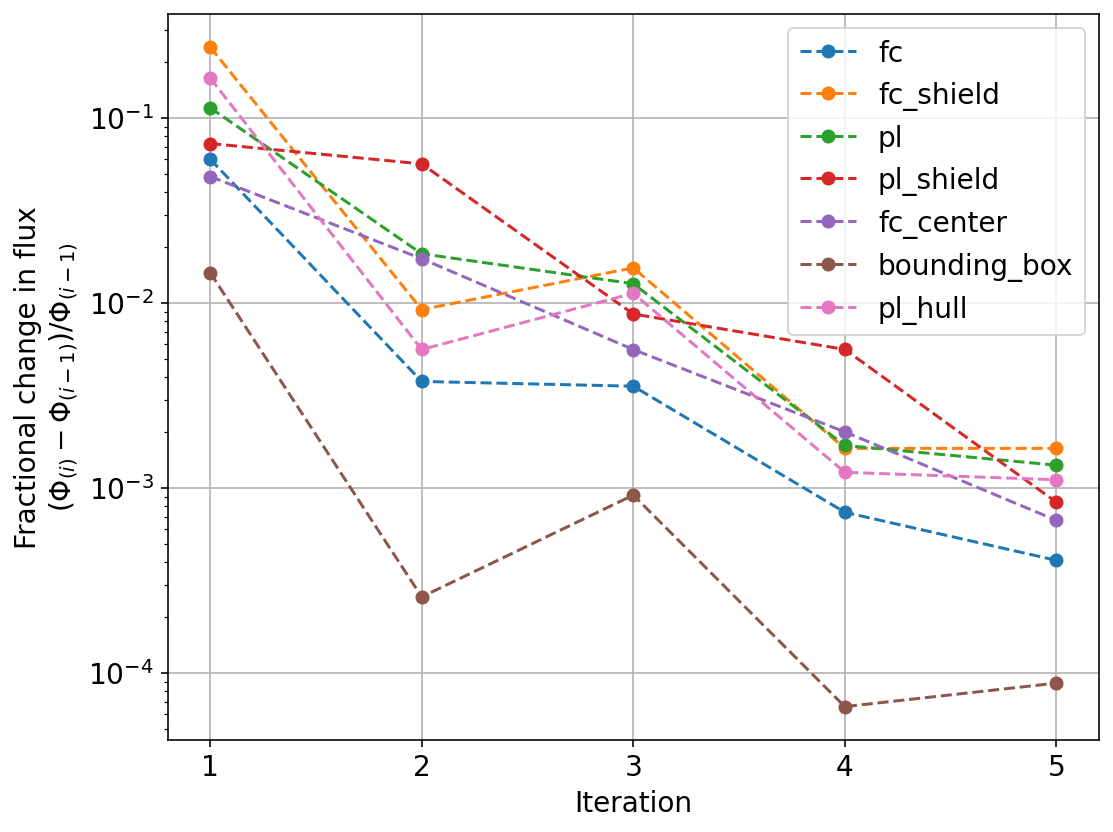

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)
for col in df.columns:
    ys = df[col].values
    ys = np.abs(np.diff(ys))[1:] / np.abs(ys)[1:-1]
    ax.plot(np.arange(len(ys)) + 1, ys, 'o--', label=col)
ax.set_ylabel("Fractional change in flux\n$(\\Phi_{(i)} -\\Phi_{(i-1)}) / \\Phi_{(i-1)}$", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_xticks(np.arange(len(ys)) + 1)
ax.set_yscale("log")
ax.legend(loc=0)
fig.tight_layout()

In [ ]:
field_coil = huber_field_coil(151)
field_coil.make_mesh(min_triangles=10000, optimesh_steps=200)

In [ ]:
ax = field_coil.plot_mesh()
ax = field_coil.plot_polygons(ax=ax, color='k', alpha=0.5, legend=False)
_ = ax.set_title(
    f"Mesh: {field_coil.points.shape[0]} points, "
    f"{field_coil.triangles.shape[0]} triangles"
)
ax.figure.set_size_inches(8,8)

In [ ]:
applied_field = sc.sources.ConstantField(0.0)

circulating_currents = {
    "fc_center": "1 mA"
}

solutions = sc.solve(
    device=field_coil,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="Phi_0/um**2",
    current_units="uA",
    iterations=1,
    coupled=False,
)
field_coil_solution = solutions[-1]

In [ ]:
fig, axes = sc.plot_currents(
    field_coil_solution,
    figsize=(6,5),
    streamplot=True,
    units="mA/um",
    cross_section_xs=0,
    cross_section_angle=0,
)
for ax in axes:
    field_coil.plot_polygons(ax=ax, legend=False, color='w', lw=0.75, alpha=0.75)

In [ ]:
field_units = "mT"

fc_fields = {}
for layer in squid.layers_list:
    fc_fields[layer.z0] = field_coil_solution.field_at_position(
        squid.points,
        zs=layer.z0,
        units=field_units,
        with_units=False,
    )

def field_coil_field(x, y, z, solution=field_coil_solution, units="mT"):
    return fc_fields[z]

In [ ]:
applied_field = field_coil_field

circulating_currents = None

solutions = sc.solve(
    device=squid,
    applied_field=applied_field,
    circulating_currents=circulating_currents,
    field_units="mT",
    current_units="uA",
    iterations=11,
    coupled=True,
)

In [ ]:
records = []
for s in solutions:
    records.append(s.polygon_flux(units="Phi_0", with_units=False))
df = pd.DataFrame.from_records(records)
df.index.name = "Iteration"

In [ ]:
df

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)
for col in df.columns:
    ys = df[col].values
    ys = np.abs(np.diff(ys))[1:] / np.abs(ys)[1:-1]
    ax.plot(np.arange(len(ys)) + 1, ys, 'o--', label=col)
ax.set_ylabel("Fractional change in flux\n$(\\Phi_{(i)} -\\Phi_{(i-1)}) / \\Phi_{(i-1)}$", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
ax.set_yscale("log")
ax.legend(loc=0)
fig.tight_layout()

In [ ]:
flux = solutions[-1].polygon_flux()
I_circ = squid.ureg(solutions[-1].circulating_currents["fc_center"])
print(f"{flux['pl_hull'].to('Phi_0'):.3e~P}")
print(
    f"{(flux['pl_hull'] / I_circ).to('Phi_0/A'):.3f~P} = "
    f"{(flux['pl_hull'] / I_circ).to('pH'):.3f~P}"
)

In [ ]:
for solution in solutions[-1:]:
    fig, axes = sc.plot_fields(
        solution,
        units="mT",
        cmap="coolwarm",
        figsize=(10,6),
        grid_shape=(1000, 1000),
        cross_section_xs=0,
        cross_section_angle=0,
        vmin=-0.4, vmax=0.4,
    )
    for ax in axes:
        squid.plot_polygons(ax=ax, legend=False, color='k', lw=0.75)
        field_coil.plot_polygons(ax=ax, legend=False, color='k', lw=0.75)

In [ ]:
for solution in solutions[-1:]:
    fig, axes = sc.plot_currents(
        solution,
        figsize=(10,6),
        streamplot=False,
        units="mA/um",
        cross_section_xs=0,
        cross_section_angle=0,
    )
    for ax in axes:
        squid.plot_polygons(ax=ax, legend=False, color='w', lw=0.75, alpha=0.75)
        field_coil.plot_polygons(ax=ax, legend=False, color='w', lw=0.75, alpha=0.75)

In [ ]:
img = plt.imread("huber-image.png")
scale = np.where(img[385][:,0] == 1)[0].size / 5 # pixels per micron

origin = x0, y0 = (465, 610)

In [ ]:
polygons = {
    name: scale * sc.geometry.rotate(points, 0)
    for name, points in huber_geometry(interp_points=101).items()
}

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
im = ax.imshow(img[:-200])
ax.set_yticks([])
ax.set_xticks([])

for name, points in polygons.items():
    if name in ["pl_hull", "fc_shield"]:
        continue
    xs, ys = points.T
    xs = -xs
    xs = xs + x0
    ys = ys + y0
    ax.plot(xs, ys, color='w', alpha=0.8, lw=2)
    
_ = ax.set_xlim(0, img.shape[1]-1)